# Quantile Regression

This example page shows how to use <i><b>statsmodels' QuantReg </b></i> class to replicate parts of the analysis published in

 - Koenker, Roger and Kevin F. Hallock. "Quantile Regressioin". Journal of Economic Perspectives, Volume 15, Number 4, Fall 2001, Pages 143–156
 
We are interested in the relationship between income and expenditures on food for a sample of working class Belgian households in 1857 (the Engel data).

## Setup
We first need to load some modules and to retrieve the data. Conveniently, the Engel dataset is shipped with <i><b>statsmodels</b></i>

In [1]:
%matplotlib inline

# from __future__ import print_function
import patsy
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from statsmodels.regression.quantile_regression import QuantReg

data = sm.datasets.engel.load_pandas().data
data.head()

,income,foodexp
0,420.157651,255.839425
1,541.411707,310.958667
2,901.157457,485.680014
3,639.080229,402.997356
4,750.875606,495.560775


## Least Absolute Deviation
The LAD model is a special case of quantile regression where q=0.5

In [2]:
mod = smf.quantreg('foodexp ~ income', data)
res = mod.fit(q=.5)
print(res.summary())

                         QuantReg Regression Results                          
Dep. Variable:                foodexp   Pseudo R-squared:               0.6206
Model:                       QuantReg   Bandwidth:                       64.51
Method:                 Least Squares   Sparsity:                        209.3
Date:                Mon, 21 Jan 2019   No. Observations:                  235
Time:                        14:13:26   Df Residuals:                      233
                                        Df Model:                            1
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     81.4823     14.634      5.568      0.000      52.649     110.315
income         0.5602      0.013     42.516      0.000       0.534       0.586

The condition number is large, 2.38e+03. This might indicate that there are
strong multicollinearity or other numerical problems.


/home/manhtruong/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


## Visualizing the results
We estimate the quantile regression model for many quantiles between .05 and .95, and compare best fit line from each of these models to Ordinary Least Squares results.

### Prepare data to plotting
For convenience, we place the quantile regression results in a Pandas DataFrame, and the OLS results in a dictionary.

In [3]:
quantiles = np.arange(0.05, 0.96, 0.1)
quantiles

array([0.05, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95])

In [4]:
def fit_model(q):
    res = mod.fit(q=q)
    return [q, res.params['Intercept'], res.params['income']] + res.conf_int().loc['income'].tolist()

models = [fit_model(x) for x in quantiles]
models = pd.DataFrame(models, columns=['q', 'a', 'b', 'lb', 'ub'])
ols = smf.ols('foodexp ~ income', data).fit()
ols_ci = ols.conf_int().loc['income'].tolist()
ols = dict(a = ols.params['Intercept'], 
          b = ols.params['income'],
          lb = ols_ci[0],
          ub = ols_ci[1])
print(models)
print(ols)

      q           a         b        lb        ub
0  0.05  124.880096  0.343361  0.268632  0.418090
1  0.15  111.693660  0.423708  0.382780  0.464636
2  0.25   95.483539  0.474103  0.439900  0.508306
3  0.35  105.841294  0.488901  0.457759  0.520043
4  0.45   81.083647  0.552428  0.525021  0.579835
5  0.55   89.661370  0.565601  0.540955  0.590247
6  0.65   74.033435  0.604576  0.582169  0.626982
7  0.75   62.396584  0.644014  0.622411  0.665617
8  0.85   52.272216  0.677603  0.657383  0.697823
9  0.95   64.103964  0.709069  0.687831  0.730306
{'a': 147.4753885237058, 'b': 0.4851784236769232, 'lb': 0.45687381301842295, 'ub': 0.5134830343354234}


First plot¶
This plot compares best fit lines for 10 quantile regression models to the least squares fit. As Koenker and Hallock (2001) point out, we see that:

 - Food expenditure increases with income
 - The dispersion of food expenditure increases with income
 - The least squares estimates fit low income observations quite poorly (i.e. the OLS line passes over most low income households)

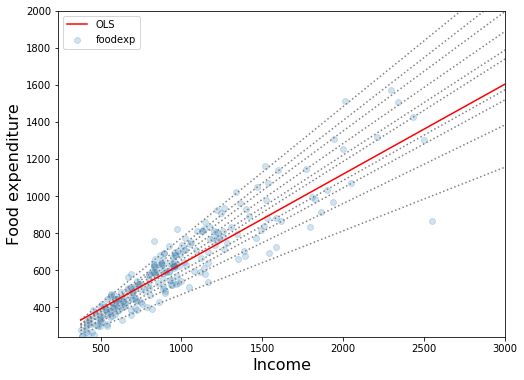

In [5]:
x = np.arange(data.income.min(), data.income.max(), 50)
get_y = lambda a, b: a + b * x

fig, ax = plt.subplots(figsize=(8, 6))

for i in range(models.shape[0]):
    y = get_y(models.a[i], models.b[i])
    ax.plot(x, y, linestyle='dotted', color='grey')
    
y = get_y(ols['a'], ols['b'])

ax.plot(x, y, color='red', label='OLS')
ax.scatter(data.income, data.foodexp, alpha=.2)
ax.set_xlim((240, 3000))
ax.set_ylim((240, 2000))
legend = ax.legend()
ax.set_xlabel('Income', fontsize=16)
ax.set_ylabel('Food expenditure', fontsize=16);

### Second plot

The dotted black lines form 95% point-wise confidence band around 10 quantile regression estimates (solid black line). The red lines represent OLS regression results along with their 95% confindence interval.

In most cases, the quantile regression point estimates lie outside the OLS confidence interval, which suggests that the effect of income on food expenditure may not be constant across the distribution.

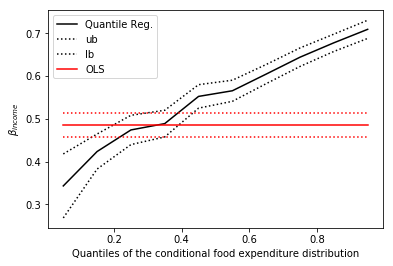

In [6]:
n = models.shape[0]
p1 = plt.plot(models.q, models.b, color='black', label='Quantile Reg.')
p2 = plt.plot(models.q, models.ub, linestyle='dotted', color='black')
p3 = plt.plot(models.q, models.lb, linestyle='dotted', color='black')
p4 = plt.plot(models.q, [ols['b']] * n, color='red', label='OLS')
p5 = plt.plot(models.q, [ols['lb']] * n, linestyle='dotted', color='red')
p6 = plt.plot(models.q, [ols['ub']] * n, linestyle='dotted', color='red')
plt.ylabel(r'$\beta_{income}$')
plt.xlabel('Quantiles of the conditional food expenditure distribution')
plt.legend()
plt.show()